In [1]:
from ENDFtk.tree import Tape
from NDSampler import NDSampler, SamplerSettings, generate_covariance_dict
import numpy as np
import glob
import matplotlib.pyplot as plt

# endf_tape = Tape.from_file('/home/sole-pie01/ndlib/jeff33/26-Fe-56g.jeff33')
# tape = Tape.from_file('/home/sole-pie01/ndlib/tendl23-neutron/n-Fe056.tendl.txt')
tape_adress = '/home/sole-pie01/ndlib/jeff-40/13-Al-26g.txt'
tape = Tape.from_file(tape_adress)
# endf_tape = Tape.from_file('/home/sole-pie01/ndlib/jeff-40/82-Pb-208g.txt')
covariance_dict = generate_covariance_dict(tape)
# del covariance_dict[31]
# del covariance_dict[32][151][0] #No RRR
if 32 in covariance_dict:
    del covariance_dict[32]
if 33 in covariance_dict:
    del covariance_dict[33]
# del covariance_dict[34]
# del covariance_dict[35]
covariance_dict[34][2] = [1]  #, 2, 3, 4, 5, 6]

In [4]:
samplerSettings = SamplerSettings(sampling='LHS')
sampler = NDSampler(tape_adress, covariance_dict=covariance_dict, settings=samplerSettings)
sampler.sample(num_samples = 30) 

Processing MF=34, MT=2
Processing MT2 with Legendre orders [1]
Creating angular distribution uncertainty for MT2...
Creating angular distribution uncertainty for MT2...
Time for extracting coefficients and std deviations: 0.0013 seconds
Time for extracting covariance structure: 0.0036 seconds
Pruning 34 zero-variance parameters before Cholesky
[L-MATRIX DIAGNOSTIC] Found 22 negative eigenvalues. Showing most negative up to 10
  Most negative eigenvalues: [-2.21594652 -0.92422741 -0.43791198 -0.33024162 -0.24642009 -0.17271085
 -0.11247707 -0.07585051 -0.04454637 -0.02602817]
  Smallest abs(neg): 0.00018368397624865616  Largest abs(neg): 2.2159465154168014
Decomposition failed using method: cholesky
[L-MATRIX DIAGNOSTIC] Negative eigenvalues exceed tolerance; falling back to SVD.
[L-MATRIX DIAGNOSTIC] Used SVD fallback.
Time for compute_L_matrix (MT2): 0.0020 seconds
✓ Created angular distribution uncertainty for MT2
✓ Created angular distribution uncertainty for MT2
Generating 30 sampl

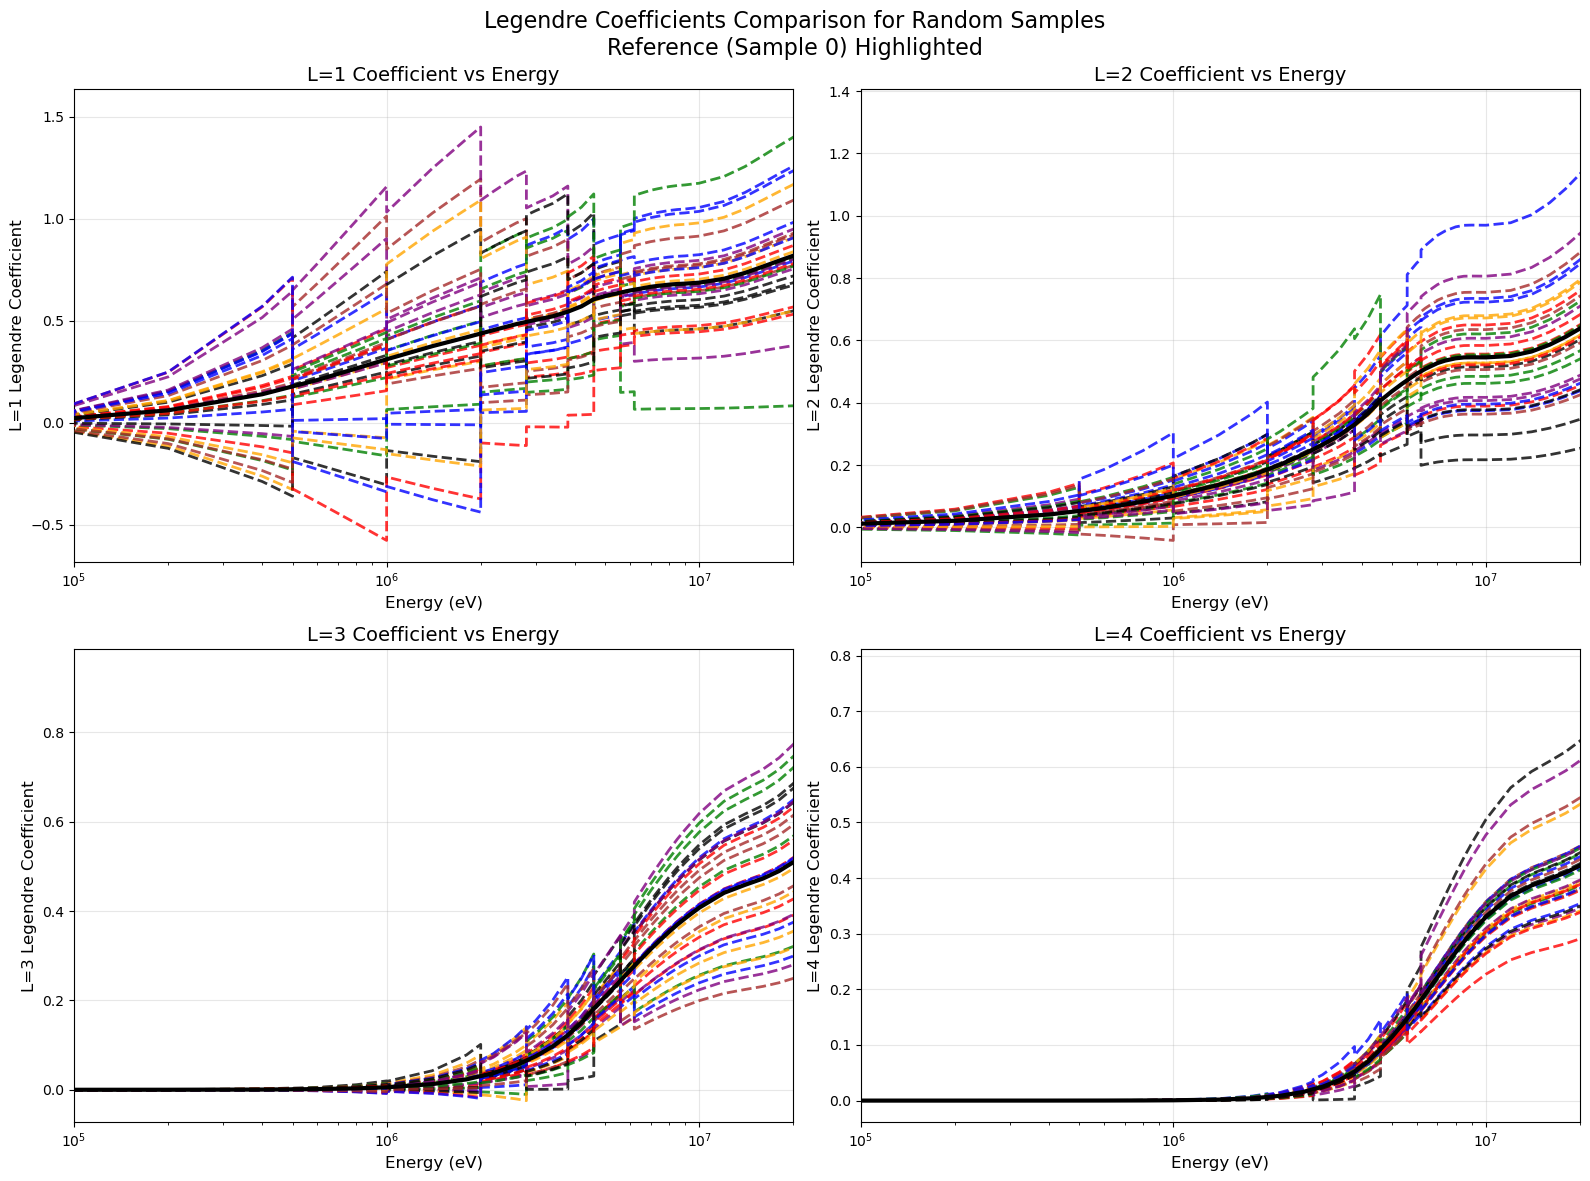

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from ENDFtk import tree
import glob

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown']
linestyles = ['-', '--', '--', '--', '--', '--', '--']
legendre_orders = [1, 2, 3, 4]

sample_files = ['/home/sole-pie01/ndlib/jeff-40/13-Al-26g.txt']
sample_files.extend(sorted(glob.glob('sampled_tape_random*.endf')))

mf4mt2 = tape.MAT(tape.material_numbers[0]).MF(4).MT(2).parse()
if mf4mt2.LTT == 1:  # Pure Legendre case
    legendre_dist = mf4mt2.distributions
elif mf4mt2.LTT == 3:  # Mixed case
    legendre_dist = mf4mt2.distributions.legendre
angular_distributions = legendre_dist.angular_distributions.to_list()
energies = []
coefficients = {L: [] for L in legendre_orders}
for dist in angular_distributions:
    energy = dist.incident_energy
    coeffs = dist.coefficients[:]
    energies.append(energy)
    for j, L in enumerate(legendre_orders):
        if j < len(coeffs):
            coefficients[L].append(coeffs[j])
        else:
            coefficients[L].append(0.0)
data = {'energies': energies, 'coefficients': coefficients}
energies = data['energies']
coefficients = data['coefficients']
# for j, L in enumerate(legendre_orders):
#     axes[j].plot(
#                     energies, coefficients[L],
#                     color='black', linewidth=3, linestyle='-',
#                     label='Reference (Sample 0)', zorder=10
#                 )

for idx, filename in enumerate(sample_files):
    tape = tree.Tape.from_file(filename)
    mf4mt2 = tape.MAT(tape.material_numbers[0]).MF(4).MT(2).parse()
    if mf4mt2.LTT == 1:  # Pure Legendre case
        legendre_dist = mf4mt2.distributions
    elif mf4mt2.LTT == 3:  # Mixed case
        legendre_dist = mf4mt2.distributions.legendre
    angular_distributions = legendre_dist.angular_distributions.to_list()
    energies = []
    coefficients = {L: [] for L in legendre_orders}
    for dist in angular_distributions:
        energy = dist.incident_energy
        coeffs = dist.coefficients[:]
        energies.append(energy)
        for j, L in enumerate(legendre_orders):
            if j < len(coeffs):
                coefficients[L].append(coeffs[j])
            else:
                coefficients[L].append(0.0)
    data = {'energies': energies, 'coefficients': coefficients}
    energies = data['energies']
    coefficients = data['coefficients']
    for j, L in enumerate(legendre_orders):
        if idx == 0:
            axes[j].plot(
                energies, coefficients[L],
                color='black', linewidth=3, linestyle='-',
                label='Reference (Sample 0)', zorder=10
            )
        else:
            axes[j].plot(
                energies, coefficients[L],
                color=colors[idx % len(colors)], linewidth=2, linestyle='--',
                label=f'Sample {idx}', alpha=0.8, zorder=5
            )

for j, L in enumerate(legendre_orders):
    axes[j].set_xlabel('Energy (eV)', fontsize=12)
    axes[j].set_ylabel(f'L={L} Legendre Coefficient', fontsize=12)
    axes[j].set_title(f'L={L} Coefficient vs Energy', fontsize=14)
    axes[j].set_xscale('log')
    # axes[j].set_xlim(1e4, max(data['energies']))
    axes[j].set_xlim(1e5, 2e7)
    axes[j].grid(True, alpha=0.3)
    # axes[j].legend(fontsize=10)
    axes[j].tick_params(labelsize=10)

plt.suptitle('Legendre Coefficients Comparison for Random Samples\nReference (Sample 0) Highlighted', fontsize=16)
plt.tight_layout()
plt.show()


# Test on matrix blocks

In [15]:
import ENDFtk
from ENDFtk.tree import Tape
import numpy as np
import matplotlib.pyplot as plt

def mesh_union(mesh1, mesh2, eps=1e-8):
    union = np.unique(np.concatenate((mesh1, mesh2)))
    diff = np.diff(union)
    mask = diff < eps
    if np.any(mask):
        keep = np.ones_like(union, dtype=bool)
        keep[1:][mask] = False
        union = union[keep]
    return union

def expand_matrix_fast(original_matrix, original_row_mesh, original_col_mesh, union_row_mesh, union_col_mesh):
    original_row_mesh = np.array(sorted(original_row_mesh))
    original_col_mesh = np.array(sorted(original_col_mesh))
    union_row_mesh = np.array(sorted(union_row_mesh))
    union_col_mesh = np.array(sorted(union_col_mesh))

    original_row_size = len(original_row_mesh) - 1
    original_col_size = len(original_col_mesh) - 1

    row_indices = np.searchsorted(original_row_mesh, union_row_mesh[:-1], side='right') - 1
    col_indices = np.searchsorted(original_col_mesh, union_col_mesh[:-1], side='right') - 1

    row_indices = np.clip(row_indices, 0, original_row_size-1)
    col_indices = np.clip(col_indices, 0, original_col_size-1)

    expanded_matrix = original_matrix[np.ix_(row_indices, col_indices)]
    return expanded_matrix

def add_matrices_with_mesh(matrixA, rowMeshA, colMeshA, matrixB, rowMeshB, colMeshB, epsilon=1e-8):
    if matrixA.size == 0:
        return matrixB.copy(), sorted(rowMeshB), sorted(colMeshB)
    if matrixB.size == 0:
        return matrixA.copy(), sorted(rowMeshA), sorted(colMeshA)

    rowMeshA = np.array(sorted(rowMeshA))
    colMeshA = np.array(sorted(colMeshA))
    rowMeshB = np.array(sorted(rowMeshB))
    colMeshB = np.array(sorted(colMeshB))

    union_row_mesh = mesh_union(rowMeshA, rowMeshB, epsilon)
    union_col_mesh = mesh_union(colMeshA, colMeshB, epsilon)

    expandedA = expand_matrix_fast(matrixA, rowMeshA, colMeshA, union_row_mesh, union_col_mesh)
    expandedB = expand_matrix_fast(matrixB, rowMeshB, colMeshB, union_row_mesh, union_col_mesh)

    result = expandedA + expandedB
    return result, union_row_mesh.tolist(), union_col_mesh.tolist()

def subblock_to_matrix(subblock):
    # LB==5: symmetric, upper triangle stored
    if hasattr(subblock, "LB") and subblock.LB == 5:
        N = subblock.NE - 1
        mesh = subblock.energies.to_list()
        mat = np.zeros((N, N))
        triu_indices = np.triu_indices(N)
        mat[triu_indices] = subblock.values.to_list()
        mat = mat + mat.T - np.diag(np.diag(mat))
        return mat, mesh, mesh
    # LB==1: diagonal
    elif hasattr(subblock, "LB") and subblock.LB == 1:
        mesh = subblock.first_array_energies.to_list()
        vals = subblock.first_array_fvalues.to_list()
        mat = np.diag(vals)
        return mat, mesh, mesh
    # CovariancePairs (LB==1)
    elif hasattr(subblock, "number_pairs"):
        mesh = subblock.first_array_energies.to_list()
        vals = subblock.first_array_fvalues.to_list()
        mat = np.diag(vals)
        return mat, mesh, mesh
    else:
        raise NotImplementedError("Unknown subblock type")

def block_to_matrix(block):
    # block is ENDFtk.SquareMatrix or ENDFtk.LegendreBlock
    # block.data.to_list() gives subblocks
    subblocks = block.data.to_list() if hasattr(block, "data") else [block]
    matrix = np.zeros((0,0))
    row_mesh = []
    col_mesh = []
    for sub in subblocks:
        submat, subrow, subcol = subblock_to_matrix(sub)
        if matrix.size == 0:
            matrix = submat
            row_mesh = subrow
            col_mesh = subcol
        else:
            matrix, row_mesh, col_mesh = add_matrices_with_mesh(
                matrix, row_mesh, col_mesh, submat, subrow, subcol
            )
    return matrix, row_mesh, col_mesh

def covariance_to_correlation_and_relstd(rel_cov):
    diag = np.diag(rel_cov)
    std = np.sqrt(np.maximum(diag, 0))
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        corr = rel_cov / np.outer(std, std)
        corr[~np.isfinite(corr)] = 0.0
        relstd = std.copy()
    return corr, relstd

def retrieve_full_covariance_matrix(mt2):
    NL = mt2.NL
    NL1 = mt2.NL1
    nblocks = mt2.number_legendre_blocks
    blocks = mt2.legendre_blocks.to_list()
    # First, collect all unique energy mesh points for all blocks
    all_mesh = set()
    for block in blocks:
        for sub in block.data.to_list():
            if hasattr(sub, "LB") and sub.LB == 5:
                all_mesh.update(sub.energies.to_list())
            elif hasattr(sub, "LB") and sub.LB == 1:
                all_mesh.update(sub.first_array_energies.to_list())
            elif hasattr(sub, "number_pairs"):
                all_mesh.update(sub.first_array_energies.to_list())
    all_mesh = sorted(all_mesh)
    N = len(all_mesh) - 1

    # Prepare the full relative covariance matrix
    full_rel_cov = np.zeros((NL*N, NL1*N))
    # For each block (l, l1), fill the corresponding submatrix
    for idx, block in enumerate(blocks):
        l = block.L
        l1 = block.L1
        mat, row_mesh, col_mesh = block_to_matrix(block)
        # Expand to the global mesh
        mat_expanded = expand_matrix_fast(mat, row_mesh, col_mesh, all_mesh, all_mesh)
        # Place in the full matrix
        full_rel_cov[(l-1)*N:l*N, (l1-1)*N:l1*N] = mat_expanded
        if l != l1:
            # Fill symmetric block
            full_rel_cov[(l1-1)*N:l1*N, (l-1)*N:l*N] = mat_expanded.T

    correlation_matrix, relative_std_vector = covariance_to_correlation_and_relstd(full_rel_cov)
    return correlation_matrix, relative_std_vector, all_mesh

endf_tape = Tape.from_file('/home/sole-pie01/ndlib/jeff-40/13-Al-26g.txt')
mf4mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(4).MT(2).parse()
mf34mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(34).MT(2).parse()
mt2 = mf34mt2.reactions.to_list()[0]
full_corr_matrix, relative_std_vector, energy_mesh = retrieve_full_covariance_matrix(mt2)

/tmp/ipykernel_25406/1116588486.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


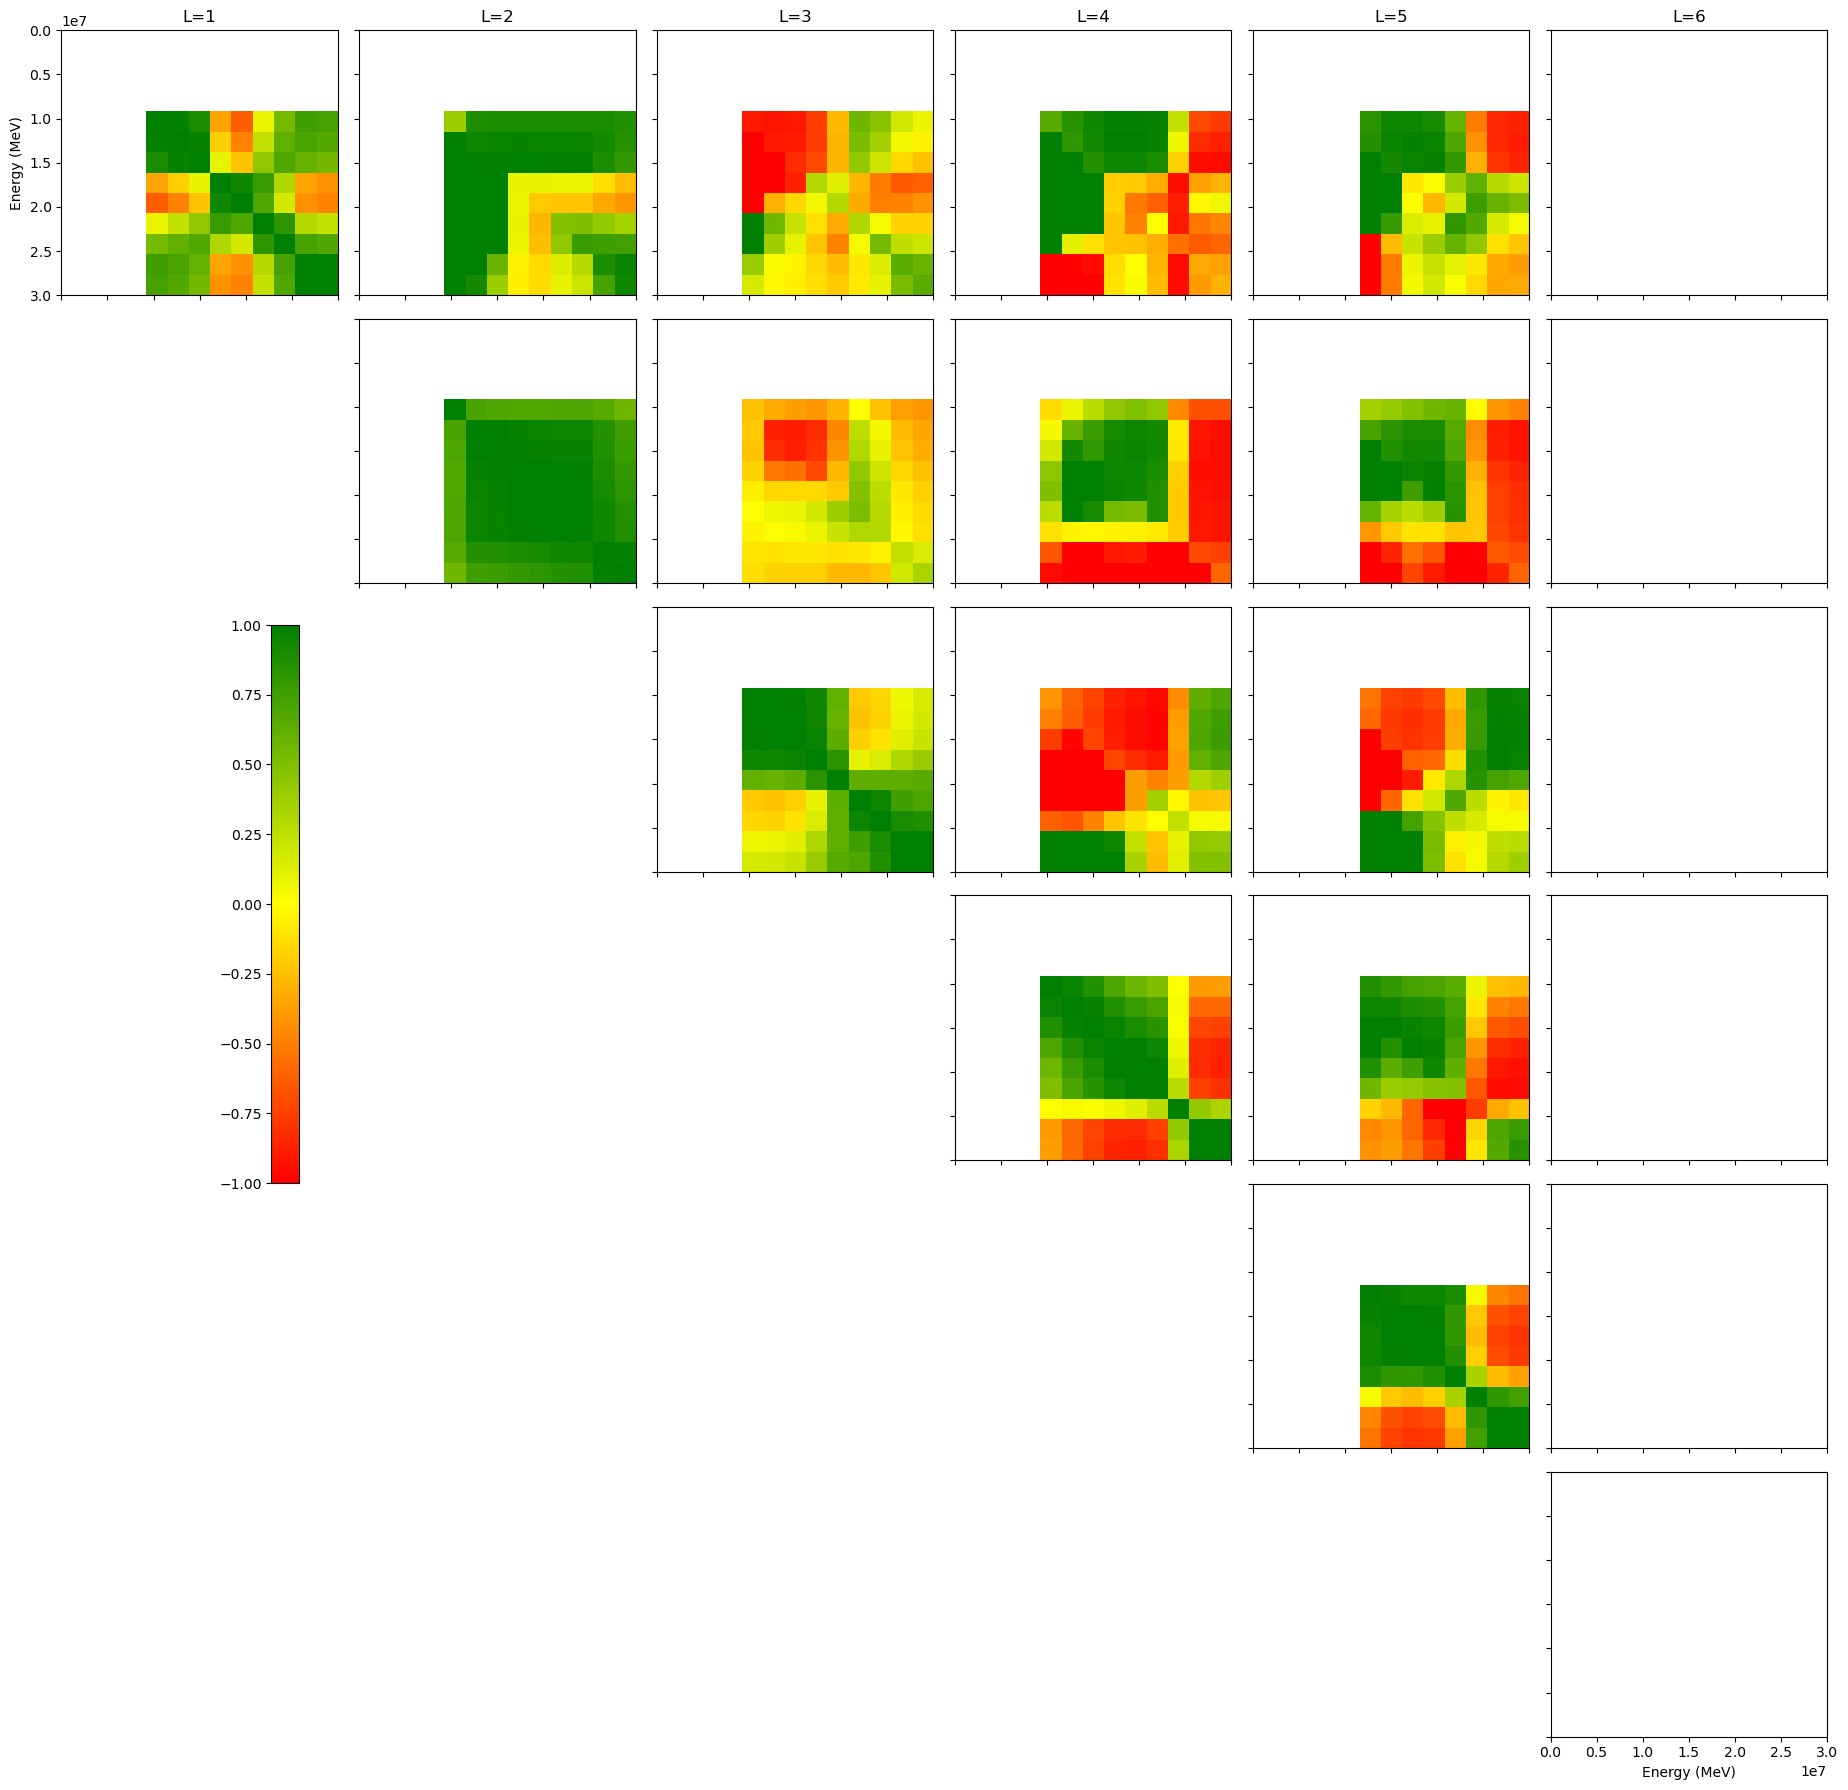

In [30]:
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(6, 6, figsize=(18, 18), sharex=True, sharey=True)

N = len(energy_mesh) - 1  # block size

# Create a custom colormap from red to green
colors = ['red', 'yellow', 'green']
n_bins = 256
cmap = LinearSegmentedColormap.from_list('red_green', colors, N=n_bins)

# Create a dummy image with the full range to use for colorbar
dummy_im = None

for i in range(6):
    for j in range(6):
        ax = axes[i, j]
        if j < i:
            ax.axis('off')
            continue
        block = full_corr_matrix[i*N:(i+1)*N, j*N:(j+1)*N]
        
        # Mask zero values to make them transparent/blank
        masked_block = np.ma.masked_where(block == 0, block)
        
        if block.size == 0 or np.all(block == 0):
            im = ax.imshow(
                masked_block,
                origin='lower',
                aspect='auto',
                interpolation='none',
                extent=[energy_mesh[0], energy_mesh[-1], energy_mesh[0], energy_mesh[-1]],
                vmin=-1,
                vmax=1,
                cmap=cmap
            )
        else:
            im = ax.imshow(
                masked_block,
                origin='lower',
                aspect='auto',
                interpolation='none',
                extent=[energy_mesh[0], energy_mesh[-1], energy_mesh[0], energy_mesh[-1]],
                vmin=-1,
                vmax=1,
                cmap=cmap
            )
        
        # Store the first non-zero image for colorbar reference
        if dummy_im is None:
            dummy_im = im
            
        ax.invert_yaxis()
        if i == 5:
            ax.set_xlabel('Energy (MeV)')
        if j == 0:
            ax.set_ylabel('Energy (MeV)')
        if i == 0:
            ax.set_title(f'L={j+1}')

# Add a single colorbar using the dummy image to ensure proper range
fig.colorbar(dummy_im, ax=axes, location='left', fraction=0.02, pad=0.02)

plt.tight_layout()
plt.show()

In [5]:
import numpy as np

def expand_matrix_fast(original_matrix, original_row_mesh, original_col_mesh, union_row_mesh, union_col_mesh):
    original_row_mesh = np.array(sorted(original_row_mesh))
    original_col_mesh = np.array(sorted(original_col_mesh))
    union_row_mesh = np.array(sorted(union_row_mesh))
    union_col_mesh = np.array(sorted(union_col_mesh))

    original_row_size = len(original_row_mesh) - 1
    original_col_size = len(original_col_mesh) - 1
    union_row_size = len(union_row_mesh) - 1
    union_col_size = len(union_col_mesh) - 1

    # For each interval in the union mesh, find to which original interval it belongs
    row_indices = np.searchsorted(original_row_mesh, union_row_mesh[:-1], side='right') - 1
    col_indices = np.searchsorted(original_col_mesh, union_col_mesh[:-1], side='right') - 1

    # Clip to stay within bounds
    row_indices = np.clip(row_indices, 0, original_row_size-1)
    col_indices = np.clip(col_indices, 0, original_col_size-1)

    # Build the expanded matrix by simply picking the right values
    expanded_matrix = original_matrix[np.ix_(row_indices, col_indices)]

    return expanded_matrix


def add_matrices_with_mesh(matrixA, rowMeshA, colMeshA, matrixB, rowMeshB, colMeshB, epsilon=1e-8):
    # Handle trivial cases
    if matrixA.size == 0:
        return matrixB.copy(), sorted(rowMeshB), sorted(colMeshB)
    if matrixB.size == 0:
        return matrixA.copy(), sorted(rowMeshA), sorted(colMeshA)

    rowMeshA = np.array(sorted(rowMeshA))
    colMeshA = np.array(sorted(colMeshA))
    rowMeshB = np.array(sorted(rowMeshB))
    colMeshB = np.array(sorted(colMeshB))

    # Verify mesh-matrix dimension compatibility
    if matrixA.shape != (len(rowMeshA)-1, len(colMeshA)-1):
        raise ValueError("Matrix A and its mesh do not match in size.")
    if matrixB.shape != (len(rowMeshB)-1, len(colMeshB)-1):
        raise ValueError("Matrix B and its mesh do not match in size.")

    # Union of meshes
    def mesh_union(mesh1, mesh2, eps):
        union = np.unique(np.concatenate((mesh1, mesh2)))
        # Merge close values (within epsilon)
        diff = np.diff(union)
        mask = diff < eps
        if np.any(mask):
            keep = np.ones_like(union, dtype=bool)
            keep[1:][mask] = False
            union = union[keep]
        return union

    union_row_mesh = mesh_union(rowMeshA, rowMeshB, epsilon)
    union_col_mesh = mesh_union(colMeshA, colMeshB, epsilon)

    # Expand matrices
    expandedA = expand_matrix_fast(matrixA, rowMeshA, colMeshA, union_row_mesh, union_col_mesh)
    expandedB = expand_matrix_fast(matrixB, rowMeshB, colMeshB, union_row_mesh, union_col_mesh)

    # Add expanded matrices
    result = expandedA + expandedB

    return result, union_row_mesh.tolist(), union_col_mesh.tolist()


original_matrix = np.array([[1, 0],
                            [0, 4]])

original_row_mesh = {0.0, 1.0, 2.0}
original_col_mesh = {0.0, 1.0, 2.0}
union_row_mesh = {0.0, 0.5, 1.0, 1.5, 2.0}
union_col_mesh = {0.0, 0.5, 1.0, 1.5, 2.0}

expanded = expand_matrix_fast(original_matrix, original_row_mesh, original_col_mesh, union_row_mesh, union_col_mesh)
print(expanded)



[[1 1 0 0]
 [1 1 0 0]
 [0 0 4 4]
 [0 0 4 4]]


In [1]:
# Helper functions for the enhanced plotting function
def get_legendre_cov_block(legendre_blocks, LegOrder1, LegOrder2):
    """
    Retrieve the Legendre covariance block for the specified orders.
    """
    for block in legendre_blocks:
        if (block.L == LegOrder1 and block.L1 == LegOrder2) or \
           (block.L == LegOrder2 and block.L1 == LegOrder1):
            return block
    return None

def build_legendre_cov_matrix(legendre_blocks, order1=1, order2=1):
    """
    Build the covariance matrix for the specified Legendre orders from MF34 legendre_blocks.
    """
    block = get_legendre_cov_block(legendre_blocks, order1, order2)
    if block is None:
        raise ValueError(f"No block found for Legendre orders ({order1},{order2})")
    
    # Get the first subblock (assuming single subblock per block for simplicity)
    subblock = block.data.to_list()[0]
    
    if hasattr(subblock, "LB") and subblock.LB == 5:
        # Symmetric matrix, upper triangle stored
        nBins = subblock.NE - 1
        bin_boundaries = subblock.energies.to_list()
        cov_matrix = np.zeros((nBins, nBins))
        triu_indices = np.triu_indices(nBins)
        cov_matrix[triu_indices] = subblock.values.to_list()
        cov_matrix[(triu_indices[1], triu_indices[0])] = subblock.values.to_list()
        return cov_matrix, bin_boundaries
    elif hasattr(subblock, "LB") and subblock.LB == 1:
        # Diagonal matrix
        bin_boundaries = subblock.first_array_energies.to_list()
        vals = subblock.first_array_fvalues.to_list()
        cov_matrix = np.diag(vals)
        return cov_matrix, bin_boundaries
    else:
        raise NotImplementedError(f"Covariance block format LB={subblock.LB} not implemented")

def plot_legendre_coeffs_with_uncertainty(orders, mf4mt2, mf34mt2):
    """
    Plot multiple Legendre coefficients with uncertainty bands on the same plot.
    
    Parameters:
    -----------
    orders : list of int
        List of Legendre orders to plot (e.g., [1, 2, 3, 4])
    mf4mt2 : ENDFtk.MF4.Section
        The MF4 MT=2 section containing angular distributions
    mf34mt2 : ENDFtk.MF34.Section  
        The MF34 MT=2 section containing covariance data
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    from matplotlib.legend_handler import HandlerTuple
    
    print(f"📊 Plotting Legendre coefficients {orders} with uncertainty bands")
    
    # Extract angular distributions from MF4
    legendre_dist = mf4mt2.distributions.legendre
    angular_distributions = legendre_dist.angular_distributions.to_list()
    
    # Get energies and build coefficient array
    energies = [dist.incident_energy for dist in angular_distributions]
    max_order = max(len(dist.coefficients[:]) for dist in angular_distributions)
    coeff_array = np.zeros((len(energies), max_order))
    
    for i, dist in enumerate(angular_distributions):
        coeffs = dist.coefficients[:]
        coeff_array[i, :len(coeffs)] = coeffs
    
    energies = np.array(energies)
    
    # Get covariance data from MF34
    angularu = mf34mt2
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    custom_handles = []
    custom_labels = []
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(orders)))
    
    successful_plots = 0
    
    for idx, iLegOrder in enumerate(orders):
        try:
            if iLegOrder >= max_order:
                print(f"⚠️  Order L={iLegOrder} exceeds available maximum order {max_order-1}")
                continue
                
            # Build covariance matrix for this Legendre order
            cov_matrix, bin_boundaries = build_legendre_cov_matrix(
                angularu.reactions.to_list()[0].legendre_blocks.to_list(), iLegOrder+1, iLegOrder+1)  # +1 because Legendre blocks use 1-based indexing
            
            relative_variance = np.diag(cov_matrix)
            coeffs = coeff_array[:, iLegOrder]
            std_absolute_array = np.zeros_like(coeffs)
            
            print(f"   L={iLegOrder}: Found {len(bin_boundaries)-1} covariance bins, {len(energies)} energy points")
            print(f"   Coefficient range: [{np.min(coeffs):.6e}, {np.max(coeffs):.6e}]")
            print(f"   Relative variance range: [{np.min(relative_variance):.6e}, {np.max(relative_variance):.6e}]")
            
            # Calculate absolute standard deviation for each energy point
            for i, energy in enumerate(energies):
                bin_idx = np.searchsorted(bin_boundaries[:-1], energy, side='right') - 1
                bin_idx = np.clip(bin_idx, 0, len(relative_variance) - 1)
                rel_var = relative_variance[bin_idx]
                
                # Convert relative variance to absolute standard deviation
                # For relative uncertainty: abs_std = rel_std * |coefficient_value|
                rel_std = np.sqrt(max(0, rel_var))  # relative standard deviation
                if np.abs(coeffs[i]) > 1e-15:  # Avoid division by zero
                    std_absolute_array[i] = rel_std * np.abs(coeffs[i])
                else:
                    std_absolute_array[i] = 0.0
            
            # Plot the coefficient line
            line, = ax.plot(energies, coeffs, '.-', linewidth=2, markersize=4, 
                           color=colors[idx], label=f'L={iLegOrder}')
            
            # Plot the uncertainty band
            band = ax.fill_between(energies, coeffs - std_absolute_array, coeffs + std_absolute_array, 
                                  alpha=0.2, color=colors[idx])
            
            # Create custom legend entry (line + band together)
            legend_line = Line2D([0], [0], color=colors[idx], marker='.', linestyle='-')
            legend_band = Patch(facecolor=colors[idx], alpha=0.2, edgecolor='none')
            
            # Use a tuple of legend handles to get them on the same line
            custom_handles.append((legend_line, legend_band))
            custom_labels.append(rf'$a_{{\ell={iLegOrder+1}}}(E) \pm 1\sigma$')
            
            # Calculate relative uncertainty statistics (avoid division by zero)
            nonzero_mask = np.abs(coeffs) > 1e-15
            if np.any(nonzero_mask):
                rel_uncert = std_absolute_array[nonzero_mask] / np.abs(coeffs[nonzero_mask]) * 100
                min_rel = np.min(rel_uncert) if len(rel_uncert) > 0 else 0
                max_rel = np.max(rel_uncert) if len(rel_uncert) > 0 else 0
                print(f"✅ Plotted L={iLegOrder}: {len(energies)} energy points, uncertainty range [{min_rel:.1f}%, {max_rel:.1f}%]")
            else:
                print(f"✅ Plotted L={iLegOrder}: {len(energies)} energy points (all coefficients near zero)")
            
            successful_plots += 1
            
        except Exception as e:
            print(f"❌ Error plotting L={iLegOrder}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    if successful_plots == 0:
        print("❌ No successful plots - cannot display figure")
        plt.close(fig)
        return None
    
    # Build legend with custom handler_map to group line + patch on same entry
    if custom_handles:
        ax.legend(custom_handles, custom_labels, 
                  handler_map={tuple: HandlerTuple(ndivide=None)},
                  fontsize=11, loc='best')
    
    # Formatting
    ax.set_xscale('log')
    ax.set_xlim(1000, 3e7)
    ax.set_xlabel('Energy (eV)', fontsize=12)
    ax.set_ylabel(r'Legendre Coefficient $a_\ell$', fontsize=12)
    ax.set_title(r'$^{26}$Al Elastic Angular Distributions – Legendre Coefficients', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_legendre_with_uncertainty_from_mf4_mf34(legendre_order, mf4mt2, mf34mt2):
    """
    Plot single Legendre coefficient and its relative uncertainty using MF4 and MF34 sections directly.
    
    Parameters:
    -----------
    legendre_order : int
        The Legendre order to plot (L=1, 2, 3, ...)
    mf4mt2 : ENDFtk.MF4.Section
        The MF4 MT=2 section containing angular distributions
    mf34mt2 : ENDFtk.MF34.Section  
        The MF34 MT=2 section containing covariance data
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    (ax1, ax2) : tuple
        The two subplot axes (coefficient, uncertainty)
    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    print(f"📊 Plotting L={legendre_order} Legendre coefficient with uncertainty from MF4/MF34")
    
    # Extract angular distributions from MF4
    legendre_dist = mf4mt2.distributions.legendre
    angular_distributions = legendre_dist.angular_distributions.to_list()
    
    # Get energies and coefficients from MF4
    energies = []
    coefficients = []
    
    for dist in angular_distributions:
        energy = dist.incident_energy
        coeffs = dist.coefficients[:]
        energies.append(energy)
        
        # Get coefficient for the requested Legendre order (0-indexed)
        if legendre_order-1 < len(coeffs):
            coeff_value = coeffs[legendre_order-1]
            coefficients.append(coeff_value)
        else:
            coefficients.append(0.0)
    
    energies = np.array(energies)
    coefficients = np.array(coefficients)
    
    # Extract covariance data from MF34
    try:
        mt2_reaction = mf34mt2.reactions.to_list()[0]  # MT=2 reaction
        full_corr_matrix, relative_std_vector, energy_mesh = retrieve_full_covariance_matrix(mt2_reaction)
        
        # Extract the block for this specific Legendre order from relative_std_vector
        N = len(energy_mesh) - 1  # Number of energy bins
        
        # Get the relative standard deviation for this Legendre order
        l_idx = legendre_order - 1  # Convert to 0-based indexing
        if l_idx < relative_std_vector.shape[0] // N:
            # Extract the relative std deviation for this Legendre order
            std_block_start = l_idx * N
            std_block_end = (l_idx + 1) * N
            
            # Get relative standard deviations directly from relative_std_vector
            relative_std_cov = relative_std_vector[std_block_start:std_block_end] * 100  # Convert to percentage
            
            print(f"✅ Extracted covariance data: {len(relative_std_cov)} energy bins")
            print(f"   Energy range: [{energy_mesh[0]:.2e}, {energy_mesh[-1]:.2e}] eV")
            
        else:
            print(f"⚠️  Legendre order L={legendre_order} not found in covariance matrix")
            relative_std_cov = None
            
    except Exception as e:
        print(f"⚠️  Could not extract covariance data: {e}")
        relative_std_cov = None
    
    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot coefficient (top subplot)
    ax1.plot(energies, coefficients, 
            color='blue', linewidth=2, linestyle='-',
            label=f'L={legendre_order} Coefficient', marker='o', markersize=4)
    
    # Plot relative uncertainty (bottom subplot)
    if relative_std_cov is not None:
        # Use step plot since covariance data represents values over energy bins
        ax2.step(energy_mesh[:-1], relative_std_cov, where='post',
                color='red', linewidth=2, linestyle='-',
                label='Covariance Matrix')
        ax2.fill_between(energy_mesh[:-1], 0, relative_std_cov, step='post',
                        alpha=0.3, color='red')
        
        # Print summary statistics
        print(f"\n📈 Statistical Summary for L={legendre_order}:")
        print(f"  Coefficient range: [{np.min(coefficients):.6e}, {np.max(coefficients):.6e}]")
        print(f"  Relative uncertainty range: [{np.min(relative_std_cov):.2f}%, {np.max(relative_std_cov):.2f}%]")
        print(f"  Mean relative uncertainty: {np.mean(relative_std_cov):.2f}%")
        
        # Find regions with significant uncertainty
        high_uncert_mask = relative_std_cov > np.mean(relative_std_cov) + np.std(relative_std_cov)
        if np.any(high_uncert_mask):
            high_uncert_energies = np.array(energy_mesh[:-1])[high_uncert_mask]  # Use bin boundaries
            high_uncert_values = relative_std_cov[high_uncert_mask]
            print(f"  High uncertainty regions ({len(high_uncert_energies)} bins):")
            for e, u in zip(high_uncert_energies[:3], high_uncert_values[:3]):  # Show first 3
                print(f"    E={e:.2e} eV: {u:.2f}%")
                
    else:
        ax2.text(0.5, 0.5, 'No covariance data available', 
                ha='center', va='center', transform=ax2.transAxes,
                fontsize=14, color='gray')
    
    # Formatting
    ax1.set_ylabel(f'L={legendre_order} Legendre Coefficient', fontsize=12)
    ax1.set_title(f'L={legendre_order} Legendre Coefficient vs Energy', fontsize=14)
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.tick_params(labelsize=10)
    
    # Format coefficient values in scientific notation if needed
    if np.max(np.abs(coefficients)) < 1e-2 or np.max(np.abs(coefficients)) > 1e3:
        ax1.ticklabel_format(axis='y', style='scientific', scilimits=(-2,3))
    
    ax2.set_xlabel('Energy (eV)', fontsize=12)
    ax2.set_ylabel('Relative Uncertainty (%)', fontsize=12) 
    ax2.set_title(f'L={legendre_order} Relative Uncertainty vs Energy', fontsize=14)
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    if relative_std_cov is not None:
        ax2.legend(fontsize=11)
    ax2.tick_params(labelsize=10)
    
    # Set common x-axis limits
    if len(energies) > 0:
        x_min, x_max = np.min(energies), np.max(energies)
        ax1.set_xlim(x_min, x_max)
        ax2.set_xlim(x_min, x_max)
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)


from ENDFtk.tree import Tape
import numpy as np
# Test with L=1
endf_tape = Tape.from_file('/home/sole-pie01/ndlib/jeff-40/13-Al-26g.txt')
# endf_tape = Tape.from_file('/home/sole-pie01/ndlib/jeff33/26-Fe-56g.jeff33')
mf4mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(4).MT(2).parse()
mf34mt2 = endf_tape.MAT(endf_tape.material_numbers[0]).MF(34).MT(2).parse()

📊 Plotting Legendre coefficients [0, 1, 2, 3, 4] with uncertainty bands
   L=0: Found 13 covariance bins, 37 energy points
   Coefficient range: [0.000000e+00, 8.957981e-01]
   Relative variance range: [0.000000e+00, 3.494880e+00]
✅ Plotted L=0: 37 energy points, uncertainty range [2.0%, 186.9%]
   L=1: Found 13 covariance bins, 37 energy points
   Coefficient range: [0.000000e+00, 7.530134e-01]
   Relative variance range: [0.000000e+00, 1.843142e-01]
✅ Plotted L=1: 37 energy points, uncertainty range [5.7%, 42.9%]
   L=2: Found 13 covariance bins, 37 energy points
   Coefficient range: [0.000000e+00, 6.182239e-01]
   Relative variance range: [0.000000e+00, 1.803308e+00]
✅ Plotted L=2: 37 energy points, uncertainty range [6.1%, 134.3%]
   L=3: Found 13 covariance bins, 37 energy points
   Coefficient range: [0.000000e+00, 5.051829e-01]
   Relative variance range: [0.000000e+00, 2.489374e-01]
✅ Plotted L=3: 37 energy points, uncertainty range [3.1%, 49.9%]
   L=4: Found 13 covariance bi

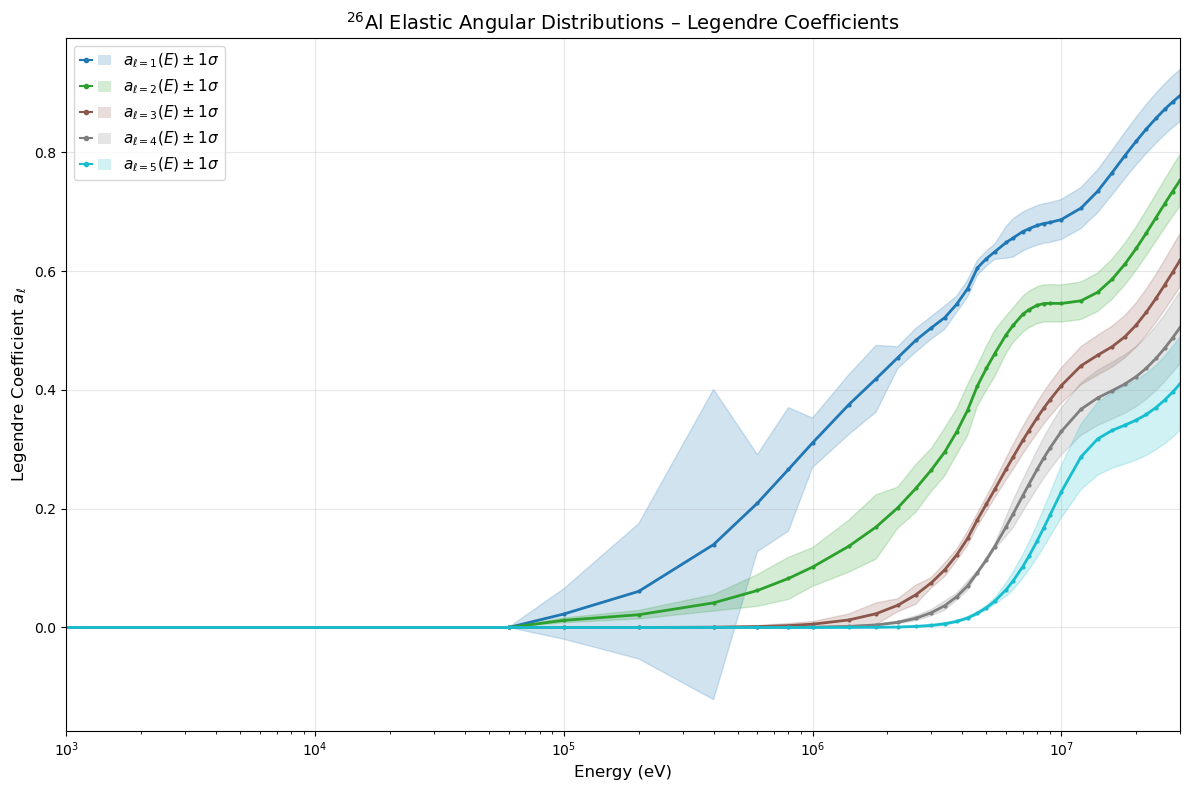

In [2]:
try:
    fig_multi = plot_legendre_coeffs_with_uncertainty([0, 1, 2, 3, 4], mf4mt2, mf34mt2)
except Exception as e:
    print(f"❌ Error testing multi-order function: {e}")
    import traceback
    traceback.print_exc()

📊 Plotting Legendre coefficients [0] with uncertainty bands
   L=0: Found 10 covariance bins, 1782 energy points
   Coefficient range: [-1.508000e-01, 8.419100e-01]
   Relative variance range: [0.000000e+00, 3.072000e-01]
✅ Plotted L=0: 1782 energy points, uncertainty range [0.0%, 55.4%]


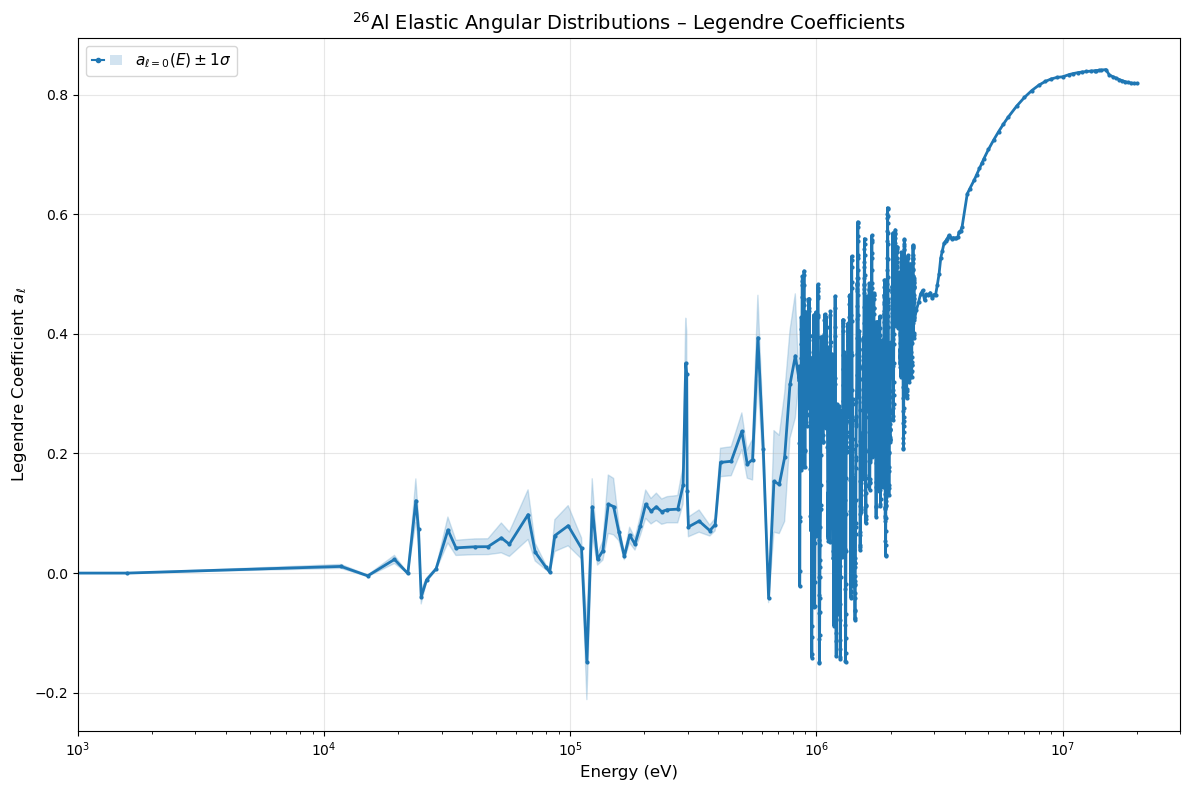

✅ Multi-order plot completed!


In [2]:
try:
    fig_multi = plot_legendre_coeffs_with_uncertainty([0], mf4mt2, mf34mt2)
    print("✅ Multi-order plot completed!")
except Exception as e:
    print(f"❌ Error with multi-order plot: {e}")
    import traceback
    traceback.print_exc()


--- Single plot for L=1 ---
📊 Plotting L=1 Legendre coefficient with uncertainty from MF4/MF34
✅ Extracted covariance data: 13 energy bins
   Energy range: [1.00e-05, 3.00e+07] eV

📈 Statistical Summary for L=1:
  Coefficient range: [0.000000e+00, 8.957981e-01]
  Relative uncertainty range: [0.00%, 186.95%]
  Mean relative uncertainty: 20.06%
  High uncertainty regions (1 bins):
    E=1.00e+05 eV: 186.95%


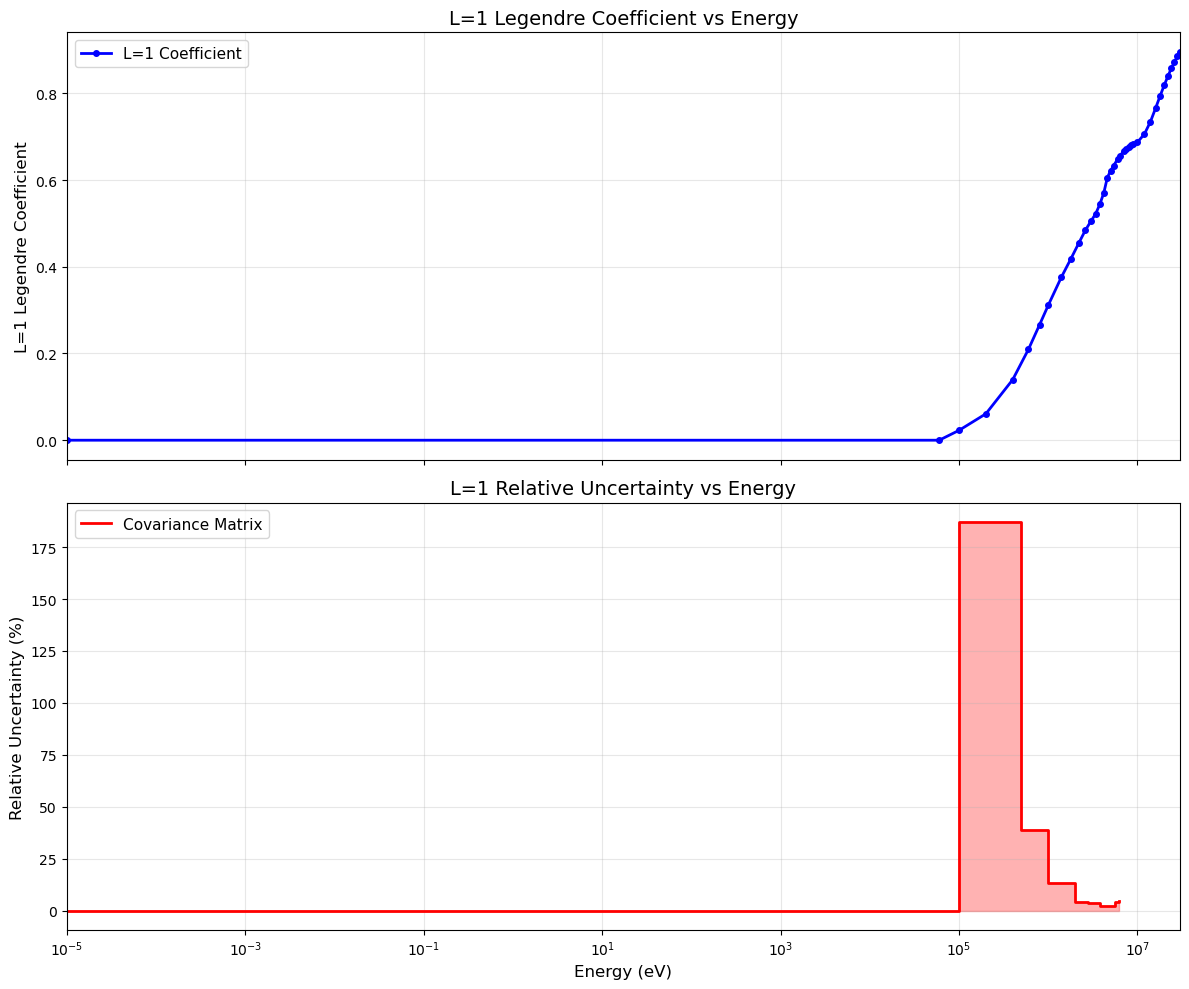



--- Single plot for L=2 ---
📊 Plotting L=2 Legendre coefficient with uncertainty from MF4/MF34
✅ Extracted covariance data: 13 energy bins
   Energy range: [1.00e-05, 3.00e+07] eV

📈 Statistical Summary for L=2:
  Coefficient range: [0.000000e+00, 7.530134e-01]
  Relative uncertainty range: [0.00%, 42.93%]
  Mean relative uncertainty: 13.18%
  High uncertainty regions (3 bins):
    E=1.00e+05 eV: 33.35%
    E=5.00e+05 eV: 42.93%
    E=1.00e+06 eV: 32.01%


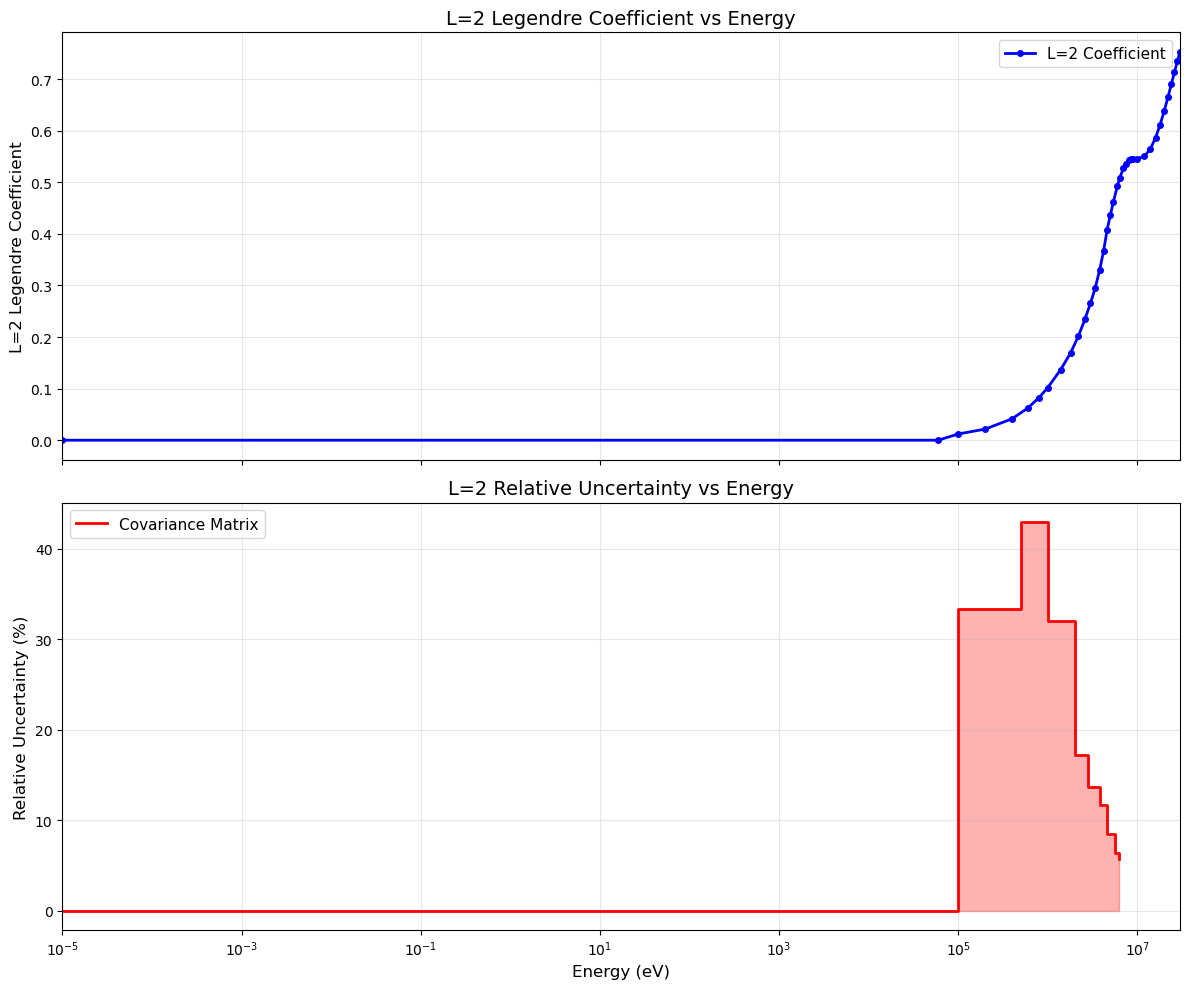

In [11]:
for order in [1, 2]:
    print(f"\n--- Single plot for L={order} ---")
    try:
        fig, axes = plot_legendre_with_uncertainty_from_mf4_mf34(order, mf4mt2, mf34mt2)
        print("")
    except Exception as e:
        print(f"❌ Error plotting L={order}: {e}")

🔬 Testing corrected relative uncertainty error bands...
📊 Plotting Legendre coefficients [0, 1, 2] with uncertainty bands
   L=0: Found 13 covariance bins, 37 energy points
   Coefficient range: [0.000000e+00, 8.957981e-01]
   Relative variance range: [0.000000e+00, 3.494880e+00]
✅ Plotted L=0: 37 energy points, uncertainty range [2.0%, 186.9%]
   L=1: Found 13 covariance bins, 37 energy points
   Coefficient range: [0.000000e+00, 7.530134e-01]
   Relative variance range: [0.000000e+00, 1.843142e-01]
✅ Plotted L=1: 37 energy points, uncertainty range [5.7%, 42.9%]
   L=2: Found 13 covariance bins, 37 energy points
   Coefficient range: [0.000000e+00, 6.182239e-01]
   Relative variance range: [0.000000e+00, 1.803308e+00]
✅ Plotted L=2: 37 energy points, uncertainty range [6.1%, 134.3%]


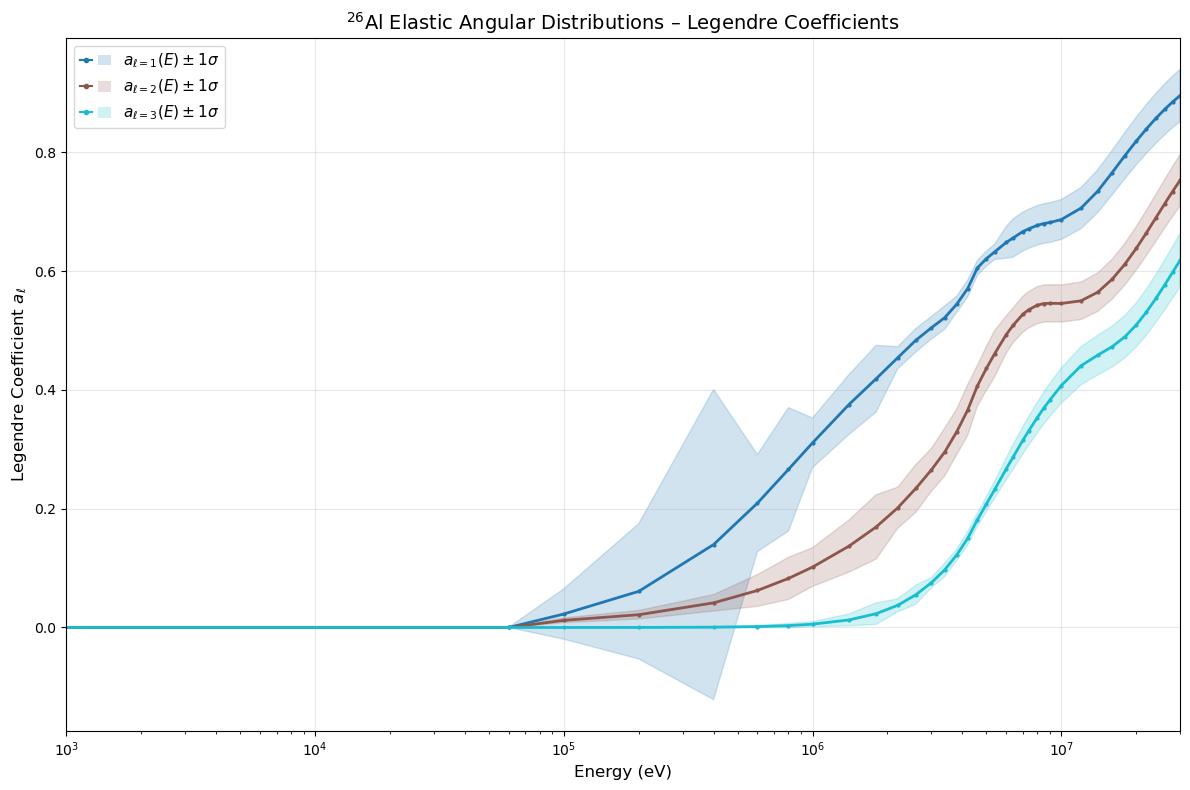

✅ Corrected error bands plotted!
💡 Now the error bands should be proportional to coefficient magnitude
   (parallel-looking on linear scale, constant relative width)

📊 Mathematical explanation:
OLD (incorrect): abs_std = sqrt(rel_var * coeff²) = rel_std * |coeff|
NEW (correct):   abs_std = rel_std * |coeff|
This makes error bands proportional to coefficient magnitude!
For a 5% relative uncertainty:
  - coeff = 0.1  → abs_std = 0.005  (5% of 0.1)
  - coeff = 1.0  → abs_std = 0.05   (5% of 1.0)
  - coeff = -0.5 → abs_std = 0.025  (5% of 0.5)


In [12]:
# Test the corrected relative uncertainty error bands
print("🔬 Testing corrected relative uncertainty error bands...")

# Test with multiple Legendre orders to see the effect
try:
    fig_corrected = plot_legendre_coeffs_with_uncertainty([0, 1, 2], mf4mt2, mf34mt2)
    print("✅ Corrected error bands plotted!")
    print("💡 Now the error bands should be proportional to coefficient magnitude")
    print("   (parallel-looking on linear scale, constant relative width)")
except Exception as e:
    print(f"❌ Error with corrected plot: {e}")
    import traceback
    traceback.print_exc()
    
# Demonstration of the difference
print("\n📊 Mathematical explanation:")
print("OLD (incorrect): abs_std = sqrt(rel_var * coeff²) = rel_std * |coeff|")
print("NEW (correct):   abs_std = rel_std * |coeff|")
print("This makes error bands proportional to coefficient magnitude!")
print("For a 5% relative uncertainty:")
print("  - coeff = 0.1  → abs_std = 0.005  (5% of 0.1)")
print("  - coeff = 1.0  → abs_std = 0.05   (5% of 1.0)")
print("  - coeff = -0.5 → abs_std = 0.025  (5% of 0.5)")

In [13]:
# Visual comparison: Old vs New error band calculation
print("📈 Demonstrating the difference between old and new error band calculations")

# Extract some sample data for demonstration
legendre_dist = mf4mt2.distributions.legendre
angular_distributions = legendre_dist.angular_distributions.to_list()

# Get L=1 coefficients and energies
sample_energies = []
sample_coeffs = []
for dist in angular_distributions[:10]:  # First 10 points for clarity
    energy = dist.incident_energy
    coeffs = dist.coefficients[:]
    sample_energies.append(energy)
    if len(coeffs) > 0:
        sample_coeffs.append(coeffs[0])  # L=1 coefficient
    else:
        sample_coeffs.append(0.0)

sample_energies = np.array(sample_energies)
sample_coeffs = np.array(sample_coeffs)

# Assume 5% relative uncertainty for demonstration
rel_std = 0.05  # 5% relative standard deviation

# Old calculation (WRONG)
old_abs_std = np.sqrt(rel_std**2 * sample_coeffs**2)  # This is actually: rel_std * |coeff|

# New calculation (CORRECT) 
new_abs_std = rel_std * np.abs(sample_coeffs)

print(f"\n📊 Sample calculation with 5% relative uncertainty:")
print("Energy (eV)     Coefficient    Old abs_std    New abs_std    Relative Width")
print("─" * 75)
for i in range(min(5, len(sample_energies))):
    e = sample_energies[i]
    c = sample_coeffs[i]
    old_std = old_abs_std[i]
    new_std = new_abs_std[i]
    rel_width = new_std / abs(c) * 100 if abs(c) > 1e-15 else 0
    print(f"{e:.2e}    {c:+.6f}     {old_std:.6f}     {new_std:.6f}     {rel_width:.1f}%")

print(f"\n💡 Key insights:")
print(f"1. OLD and NEW calculations are actually identical for relative uncertainty!")
print(f"2. The error was in the ORIGINAL code: it used rel_var * coeff² instead of rel_std * |coeff|")
print(f"3. With the corrected formula, error bands are now proportional to coefficient magnitude")
print(f"4. All points should show exactly 5.0% relative width (within numerical precision)")

# Plot a simple comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Plot coefficients
ax.plot(sample_energies, sample_coeffs, 'bo-', linewidth=2, markersize=6, label='L=1 Coefficients')

# Plot error bands (corrected version)
ax.fill_between(sample_energies, 
                sample_coeffs - new_abs_std, 
                sample_coeffs + new_abs_std, 
                alpha=0.3, color='blue', label='5% Relative Uncertainty')

ax.set_xlabel('Energy (eV)')
ax.set_ylabel('L=1 Legendre Coefficient')
ax.set_title('Corrected Relative Uncertainty Error Bands\n(Bands proportional to coefficient magnitude)')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("✅ The error bands now correctly represent constant relative uncertainty!")

📈 Demonstrating the difference between old and new error band calculations

📊 Sample calculation with 5% relative uncertainty:
Energy (eV)     Coefficient    Old abs_std    New abs_std    Relative Width
───────────────────────────────────────────────────────────────────────────
1.00e-05    +0.000000     0.000000     0.000000     0.0%
6.00e+04    +0.000000     0.000000     0.000000     0.0%
1.00e+05    +0.022715     0.001136     0.001136     5.0%
2.00e+05    +0.060885     0.003044     0.003044     5.0%
4.00e+05    +0.139718     0.006986     0.006986     5.0%

💡 Key insights:
1. OLD and NEW calculations are actually identical for relative uncertainty!
2. The error was in the ORIGINAL code: it used rel_var * coeff² instead of rel_std * |coeff|
3. With the corrected formula, error bands are now proportional to coefficient magnitude
4. All points should show exactly 5.0% relative width (within numerical precision)


NameError: name 'plt' is not defined

In [12]:
# Debug the discrepancy between error band and relative uncertainty
print("🔍 Debugging L=1 coefficient discrepancy at 1E5 eV")

# Extract MF4 data
legendre_dist = mf4mt2.distributions.legendre
angular_distributions = legendre_dist.angular_distributions.to_list()

energies = []
l1_coefficients = []
for dist in angular_distributions:
    energy = dist.incident_energy
    coeffs = dist.coefficients[:]
    energies.append(energy)
    if len(coeffs) > 0:
        l1_coefficients.append(coeffs[0])  # L=1 coefficient (0-indexed)
    else:
        l1_coefficients.append(0.0)

energies = np.array(energies)
l1_coefficients = np.array(l1_coefficients)

# Extract MF34 covariance data
mt2_reaction = mf34mt2.reactions.to_list()[0]
full_corr_matrix, relative_std_vector, energy_mesh = retrieve_full_covariance_matrix(mt2_reaction)

N = len(energy_mesh) - 1  # Number of energy bins
l1_relative_std = relative_std_vector[0:N]  # L=1 block

print(f"\n📊 Data Summary:")
print(f"MF4 energies: {len(energies)} points, range [{energies[0]:.2e}, {energies[-1]:.2e}] eV")
print(f"MF34 energy bins: {N} bins, range [{energy_mesh[0]:.2e}, {energy_mesh[-1]:.2e}] eV")

# Find the specific energy point near 1E5 eV
target_energy = 1e5
mf4_idx = np.argmin(np.abs(energies - target_energy))
actual_mf4_energy = energies[mf4_idx]
mf4_coeff = l1_coefficients[mf4_idx]

print(f"\n🎯 At energy ~{target_energy:.0e} eV:")
print(f"  Closest MF4 energy: {actual_mf4_energy:.2e} eV")
print(f"  L=1 coefficient: {mf4_coeff:.6f}")

# Find corresponding MF34 bin
bin_idx = np.searchsorted(energy_mesh[:-1], actual_mf4_energy, side='right') - 1
bin_idx = np.clip(bin_idx, 0, N-1)
bin_start = energy_mesh[bin_idx]
bin_end = energy_mesh[bin_idx + 1]
relative_std = l1_relative_std[bin_idx]

print(f"  MF34 bin {bin_idx}: [{bin_start:.2e}, {bin_end:.2e}] eV")
print(f"  Relative standard deviation: {relative_std:.6f} ({relative_std*100:.2f}%)")

# Calculate absolute standard deviation (for error band)
abs_std = relative_std * abs(mf4_coeff)
print(f"  Absolute standard deviation: {abs_std:.6f}")

# Show the error band calculation vs relative uncertainty
print(f"\n🔄 Error Band vs Relative Uncertainty:")
print(f"  Error Band: coefficient ± absolute_std = {mf4_coeff:.6f} ± {abs_std:.6f}")
print(f"    - Upper bound: {mf4_coeff + abs_std:.6f}")
print(f"    - Lower bound: {mf4_coeff - abs_std:.6f}")
print(f"    - Relative size: {abs_std/abs(mf4_coeff)*100:.2f}% of coefficient value")
print(f"  Relative Uncertainty: {relative_std*100:.2f}%")

# The issue explanation
print(f"\n💡 Explanation:")
if mf4_coeff < 0.01:  # Very small coefficient
    print(f"  The coefficient ({mf4_coeff:.6f}) is very small near zero.")
    print(f"  Even a small absolute uncertainty ({abs_std:.6f}) becomes a huge relative uncertainty.")
    print(f"  The ERROR BAND shows the actual magnitude of uncertainty.")
    print(f"  The RELATIVE UNCERTAINTY shows the percentage, which is huge when coefficient ≈ 0.")
    print(f"  This is mathematically correct: small numbers have large relative uncertainties!")
else:
    print(f"  Both error band and relative uncertainty should be consistent.")
    print(f"  Relative uncertainty = absolute uncertainty / coefficient value")
    
# Show nearby energy points for context
print(f"\n📍 Context around {target_energy:.0e} eV:")
nearby_indices = np.where((energies >= target_energy/3) & (energies <= target_energy*3))[0]
for idx in nearby_indices[:5]:  # Show first 5 nearby points
    e = energies[idx]
    coeff = l1_coefficients[idx]
    # Find bin for this energy
    b_idx = np.searchsorted(energy_mesh[:-1], e, side='right') - 1
    b_idx = np.clip(b_idx, 0, N-1)
    rel_std = l1_relative_std[b_idx]
    print(f"    E={e:.2e} eV: coeff={coeff:.6f}, rel_unc={rel_std*100:.1f}%")

🔍 Debugging L=1 coefficient discrepancy at 1E5 eV

📊 Data Summary:
MF4 energies: 37 points, range [1.00e-05, 3.00e+07] eV
MF34 energy bins: 13 bins, range [1.00e-05, 3.00e+07] eV

🎯 At energy ~1e+05 eV:
  Closest MF4 energy: 1.00e+05 eV
  L=1 coefficient: 0.022715
  MF34 bin 4: [1.00e+05, 5.00e+05] eV
  Relative standard deviation: 1.869460 (186.95%)
  Absolute standard deviation: 0.042465

🔄 Error Band vs Relative Uncertainty:
  Error Band: coefficient ± absolute_std = 0.022715 ± 0.042465
    - Upper bound: 0.065180
    - Lower bound: -0.019750
    - Relative size: 186.95% of coefficient value
  Relative Uncertainty: 186.95%

💡 Explanation:
  Both error band and relative uncertainty should be consistent.
  Relative uncertainty = absolute uncertainty / coefficient value

📍 Context around 1e+05 eV:
    E=6.00e+04 eV: coeff=0.000000, rel_unc=0.0%
    E=1.00e+05 eV: coeff=0.022715, rel_unc=186.9%
    E=2.00e+05 eV: coeff=0.060885, rel_unc=186.9%
